In this group of notebook we will test the methods implemented in the library to check if they can improve the results of the models.

In order to be as impartial as possible, we will use a KFold evaluation for each combination, with a k-value of five.

In this particular notebook, we will train the model using the `HideAndSeek` technique.

In [ ]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from semantic_segmentation_augmentations.holemakertechnique import HoleMakerPoint
from semantic_segmentation_augmentations.holesfilling import HideAndSeek

from vision_models_evaluation.core import evaluate

from sklearn.model_selection import KFold

import pandas as pd

import matplotlib.pyplot as plt

import PIL
import torchvision.transforms as transforms
from pathlib import Path
import random

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch; torch.cuda.set_device(1)

Then, we prepare the scenario: we are going to use a grape vine dataset where the semantic problem to tackle is to segmentate the RGB images into wood, leaves, grape and pole classes.

Finally, we define here the mapping functions and the masks transformations.

In [ ]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"

def get_y_fn(x):
    return Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

codes = np.loadtxt(path/'codesAll.txt', dtype=str)

from albumentations import (
  Compose,
  OneOf,
  ElasticTransform,
  GridDistortion, 
  OpticalDistortion,
  HorizontalFlip,
  Rotate,
  Transpose,
  CLAHE,
  ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0

    def __init__(self, aug): 
        self.aug = aug

    def encodes(self, x):
        img, mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transforms)

class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        if len(x) == 2:
            img, mask = x
        elif len(x) == 1:
            img = x[0]
            mask = np.zeros_like(img)

        #Convert to array
        mask = np.array(mask)

        # background = 0, leaves = 1, pole = 74 o 76, wood = 25 o 29, grape = 255
        mask[mask == 255] = 1 # grape
        mask[mask == 150] = 2 # leaves
        mask[mask == 76] = 3 ; mask[mask == 74] = 3 # pole
        mask[mask == 29] = 4 ; mask[mask == 25] = 4 # wood
        mask[mask >= 5] = 0 # resto: background

        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask
    
def decodes(mask):
    shape = mask.shape
    _mask = np.empty([*shape, 3])
    grape_c = np.array([255, 255, 255])
    leaves_c = np.array([0, 255, 0])
    pole_c = np.array([255, 0, 0])
    wood_c = np.array([0, 0, 255])
    back_c = np.array([0, 0, 0])
    
    for j in range(shape[0]):
        for i in range(shape[1]):
            if mask[j, i] == 1:
                _mask[j, i] = grape_c
            elif mask[j, i] == 2:
                _mask[j, i] = leaves_c
            elif mask[j, i] == 3:
                _mask[j, i] = pole_c
            elif mask[j, i] == 4:
                _mask[j, i] = wood_c
            else:
                _mask[j, i] = back_c
    
    return _mask.astype(np.uint8)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

While training, we will use the EarlyStopping strategy: after five epoch without improvements, the training will be stopped.

In [ ]:
esc = EarlyStoppingCallback(patience = 5, min_delta = 0.01)

Then, we define all the hparams (hyperparameters) to build the datablocks, dataloaders and learners.

In [ ]:
db_hparams = {
    "blocks": (ImageBlock, MaskBlock(codes)),
    "get_items": get_image_files,
    "get_y": get_y_fn,
    "splitter": RandomSplitter(valid_pct=0.2),
    "item_tfms": [Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
    "batch_tfms": Normalize.from_stats(*imagenet_stats)
}

dls_hparams = {
    "source": path_images,
    "bs": 2,
    "pin_memory": False
}

technique = KFold(n_splits = 5)

learner_hparams = {
    "arch": resnet50,
    "pretrained": True,
    "metrics": [DiceMulti()],
    "cbs": []
}

learning_hparams = {
    "epochs": 30,
    "base_lr": 0.001,
    "freeze_epochs": 3
}

learning_mode = "finetune"

saving_hparams = {
    "save_best": True,
    "metric": "DiceMulti",
    "model_name": "HideAndSeek"
}

In order to know how does this technique work, we can show an example:

This technique divides the image (and its mask) in a grid and deactivate some regions of the grid (removes all their information).

In this case, the `HoleMakerPoint` is the only hole maker technique that make sense to use.

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (training) that exists in the learner. Use `self.learn.training` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


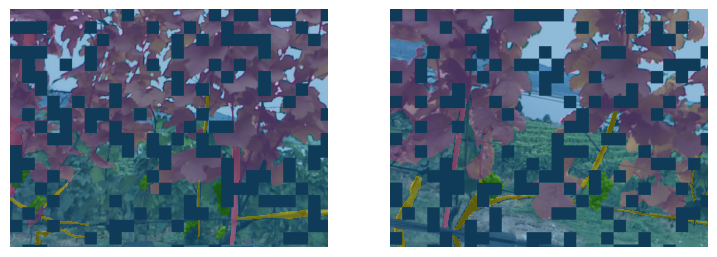

In [ ]:
cohs = HideAndSeek(deactivation_p = 0.25, hole_maker = HoleMakerPoint((25, 25)), p = 1)
dls = DataBlock(**db_hparams).dataloaders(**dls_hparams)
with Learner(dls, resnet50(), metrics=[DiceMulti()], cbs = cohs) as learn:
    learn.epoch, learn.training = 0, True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_, axs = plt.subplots(1, 2, figsize=(9, 9))
dls.show_batch(b = (cohs.x, cohs.y), ctxs = axs.flatten())

Finally, we test the model with distinct hparams.

In [ ]:
results = {}

for deactivation_p in [0.05, 0.15, 0.25]:
    for size in [(25, 25), (50, 50), (200, 200)]:
        cohs = HideAndSeek(deactivation_p = deactivation_p, hole_maker = HoleMakerPoint(size))
        learner_hparams["cbs"] = [esc, cohs]
        r = evaluate(db_hparams,
                     dls_hparams,
                     technique,
                     learner_hparams,
                     learning_hparams,
                     learning_mode,
                     saving_hparams,
                     verbose = True
                    )
        results.update({
            str(deactivation_p) + str(size): r["DiceMulti"]
        })

Starting the training for a new model
Training the fold 1


/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,dice_multi,time
0,1.113562,0.600871,0.344902,00:20
1,0.751977,0.394208,0.357735,00:19
2,0.597130,0.379159,0.405995,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.387127,0.313862,0.573521,00:19
1,0.356020,0.293552,0.665763,00:19
2,0.341941,0.278567,0.753427,00:20
3,0.326236,0.316206,0.748140,00:20
4,0.318946,0.265081,0.774830,00:19
5,0.318016,0.285646,0.747770,00:19
6,0.309680,0.307544,0.719582,00:19
7,0.307464,0.330053,0.780217,00:19
8,0.293471,0.286677,0.784204,00:19
9,0.285415,0.250461,0.790091,00:19


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.19103042781352997  /  DiceMulti: 0.858880989507961  
Saving best model because DiceMulti 0.8589 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.078097,0.776573,0.286179,00:19
1,0.696068,0.383504,0.403368,00:19
2,0.788989,0.668659,0.322907,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.502517,0.418899,0.359232,00:20
1,0.439830,0.410808,0.419907,00:20
2,0.409598,0.415487,0.558176,00:19
3,0.385641,0.312245,0.588351,00:20
4,0.365259,0.330998,0.607260,00:20
5,0.352757,0.316716,0.754685,00:20
6,0.342032,0.274237,0.777329,00:19
7,0.340168,0.273250,0.776648,00:19
8,0.320111,0.263990,0.801175,00:19
9,0.300208,0.255797,0.786817,00:20


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.24350495636463165  /  DiceMulti: 0.7932063966695196  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.152332,0.831062,0.306147,00:19
1,0.777529,0.448351,0.348631,00:20
2,0.699763,0.872569,0.134324,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.526690,0.469844,0.377184,00:20
1,0.451938,0.376277,0.545799,00:20
2,0.411330,0.342802,0.579834,00:20
3,0.384782,0.322021,0.709222,00:20
4,0.356190,0.297176,0.755045,00:20
5,0.335045,0.303090,0.737118,00:19
6,0.316648,0.288084,0.788059,00:20
7,0.305448,0.360343,0.730135,00:20
8,0.303916,0.289689,0.798313,00:20
9,0.300161,0.335084,0.766832,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.26827752590179443  /  DiceMulti: 0.8071996059356786  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.954154,0.894515,0.143081,00:19
1,0.731511,0.368069,0.360722,00:19
2,0.619222,0.442087,0.343558,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.433611,0.315566,0.604968,00:20
1,0.393099,0.285502,0.655000,00:20
2,0.362233,0.258651,0.747154,00:20
3,0.337534,0.286171,0.768325,00:20
4,0.331447,0.264235,0.778530,00:20
5,0.323723,0.250057,0.786311,00:20
6,0.333133,0.235388,0.811091,00:20
7,0.317967,0.258716,0.801230,00:21
8,0.310458,0.240326,0.810101,00:21
9,0.300371,0.234055,0.818091,00:21


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.1839306503534317  /  DiceMulti: 0.8666671922316759  
Saving best model because DiceMulti 0.8667 >= 0.8589.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.907155,0.764946,0.284650,00:20
1,0.693847,0.642964,0.311411,00:20
2,1.480847,1.190717,0.133350,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.785753,0.573040,0.334689,00:20
1,0.572955,0.401651,0.471599,00:20
2,0.466525,0.364482,0.582922,00:20
3,0.420979,0.352457,0.543030,00:21
4,0.403085,0.363241,0.634889,00:20
5,0.371028,0.305887,0.681932,00:20
6,0.345971,0.304456,0.722241,00:21
7,0.322110,0.299820,0.719256,00:21
8,0.324365,0.291763,0.773956,00:21
9,0.330938,0.293000,0.775070,00:21


No improvement since epoch 21: early stopping


Test results for the model.   validation: 0.19925981760025024  /  DiceMulti: 0.828525059873973  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.967371,0.603952,0.333733,00:20
1,0.730932,0.870604,0.256543,00:20
2,0.829840,0.993094,0.250169,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.519353,0.525698,0.499791,00:21
1,0.420787,0.517264,0.489088,00:21
2,0.376209,0.409867,0.619863,00:21
3,0.341502,0.425480,0.617420,00:21
4,0.316221,0.485380,0.640623,00:21
5,0.297693,0.482203,0.666382,00:21
6,0.287066,0.374980,0.702961,00:21
7,0.274822,0.430732,0.723306,00:21
8,0.264878,0.385007,0.708917,00:21
9,0.251772,0.477695,0.708106,00:21


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.2092517465353012  /  DiceMulti: 0.8449582745853949  
Saving best model because DiceMulti 0.845 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.143341,0.750764,0.322403,00:20
1,0.791891,0.776804,0.326022,00:20
2,0.770792,1.052802,0.160280,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.590979,0.484874,0.404302,00:21
1,0.485814,0.381483,0.404956,00:21
2,0.426946,0.335480,0.552667,00:21
3,0.382276,0.318538,0.610640,00:21
4,0.357879,0.321884,0.617246,00:21
5,0.341441,0.304331,0.701035,00:21
6,0.339602,0.313375,0.625291,00:21
7,0.319697,0.282603,0.773791,00:21
8,0.311495,0.271892,0.790066,00:21
9,0.300941,0.262757,0.780530,00:21


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.19600772857666016  /  DiceMulti: 0.8427962389317912  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.218356,0.541758,0.346476,00:20
1,0.853542,0.830704,0.250763,00:20
2,0.782722,0.951341,0.211480,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.511800,0.413975,0.355234,00:21
1,0.438428,0.354509,0.544427,00:21
2,0.405189,0.345357,0.568291,00:21
3,0.363868,0.304643,0.732874,00:21
4,0.351375,0.311059,0.741788,00:21
5,0.325963,0.289469,0.740343,00:21
6,0.317047,0.311909,0.780142,00:21
7,0.302269,0.288912,0.795666,00:21
8,0.302367,0.280803,0.780606,00:21
9,0.288385,0.273733,0.796158,00:20


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.16624969244003296  /  DiceMulti: 0.8721514177756792  
Saving best model because DiceMulti 0.8722 >= 0.845.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.916334,0.628608,0.313535,00:20
1,0.767266,0.477260,0.348743,00:20
2,0.619666,0.329479,0.450977,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.404858,0.306211,0.649573,00:21
1,0.378962,0.264470,0.725934,00:21
2,0.350505,0.232386,0.796943,00:21
3,0.329336,0.244834,0.794102,00:21
4,0.312295,0.237188,0.807016,00:21
5,0.314448,0.251941,0.811057,00:21
6,0.307375,0.257623,0.762682,00:21
7,0.298031,0.227852,0.769834,00:21


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.23599307239055634  /  DiceMulti: 0.7723273706244391  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.026588,0.757795,0.326075,00:20
1,0.687555,0.442417,0.381608,00:20
2,0.579560,0.428073,0.397144,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.383798,0.362452,0.567426,00:21
1,0.351369,0.311936,0.704922,00:21
2,0.329522,0.287359,0.752244,00:21
3,0.308779,0.287430,0.786320,00:21
4,0.300083,0.313306,0.771114,00:21
5,0.296496,0.304416,0.715275,00:21
6,0.288861,0.271149,0.794115,00:21
7,0.276710,0.264779,0.808387,00:21
8,0.284776,0.271339,0.811845,00:21
9,0.275472,0.245674,0.821414,00:21


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.23532675206661224  /  DiceMulti: 0.8146878571213276  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.797995,0.596476,0.325928,00:21
1,0.611271,0.511866,0.336306,00:21
2,7.716398,1.147351,0.190942,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.669877,0.598690,0.317958,00:21
1,0.502985,0.447106,0.342893,00:21
2,0.431995,0.441352,0.542315,00:21
3,0.378308,0.461888,0.655430,00:21
4,0.329830,0.417411,0.596135,00:21
5,0.304153,0.419217,0.681743,00:21
6,0.285970,0.392087,0.684228,00:21
7,0.281825,0.377881,0.692304,00:21
8,0.262694,0.445256,0.706586,00:21
9,0.250507,0.355926,0.733665,00:21


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.18661826848983765  /  DiceMulti: 0.8481993139080493  
Saving best model because DiceMulti 0.8482 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.938071,0.776568,0.310393,00:20
1,0.682171,0.434121,0.354042,00:21
2,0.769802,1.002233,0.136435,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.586026,0.402394,0.434563,00:21
1,0.465519,0.348023,0.527209,00:21
2,0.430998,0.383979,0.532706,00:21
3,0.399026,0.387912,0.584237,00:21
4,0.376507,0.397929,0.664831,00:21
5,0.359370,0.302746,0.704336,00:21
6,0.334552,0.269234,0.775067,00:21
7,0.319084,0.307833,0.616730,00:21
8,0.307361,0.268456,0.753824,00:21
9,0.296235,0.277507,0.755049,00:21


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.2091456800699234  /  DiceMulti: 0.8340393276291197  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.898513,0.852946,0.278692,00:20
1,0.694981,0.690098,0.338291,00:20
2,0.581003,0.362426,0.553752,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.381164,0.338049,0.632467,00:21
1,0.354218,0.332759,0.586858,00:21
2,0.334642,0.310286,0.671690,00:21
3,0.324319,0.292219,0.742149,00:21
4,0.304637,0.290631,0.783770,00:21
5,0.297829,0.297441,0.652834,00:21
6,0.304133,0.472749,0.659350,00:21
7,0.300494,0.302439,0.775962,00:21
8,0.289973,0.270946,0.798427,00:21
9,0.270327,0.267359,0.800165,00:21


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.16875788569450378  /  DiceMulti: 0.8623826040811273  
Saving best model because DiceMulti 0.8624 >= 0.8482.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.942949,0.659562,0.349724,00:20
1,0.699084,0.365584,0.358950,00:20
2,0.566465,0.376130,0.366016,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.368531,0.270734,0.702518,00:21
1,0.340691,0.244225,0.787092,00:21
2,0.329352,0.236310,0.744317,00:21
3,0.312404,0.253307,0.817816,00:21
4,0.307993,0.247622,0.801153,00:21
5,0.308298,0.248325,0.739859,00:21
6,0.317778,0.244498,0.810025,00:21


No improvement since epoch 1: early stopping


Test results for the model.   validation: 0.25201085209846497  /  DiceMulti: 0.8057385404508303  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.101208,0.693322,0.333820,00:20
1,0.725011,0.450082,0.401950,00:21
2,0.643423,0.659063,0.340493,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.422968,0.413742,0.421750,00:21
1,0.391394,0.365090,0.521848,00:21
2,0.364575,0.344282,0.665430,00:21
3,0.345408,0.299888,0.726354,00:21
4,0.323160,0.277252,0.768588,00:21
5,0.311029,0.274412,0.757815,00:21
6,0.302603,0.288849,0.775139,00:21
7,0.314217,0.281928,0.797106,00:21
8,0.318231,0.266464,0.795740,00:21
9,0.295954,0.277442,0.789011,00:21


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.21711449325084686  /  DiceMulti: 0.8084501575899761  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.835906,0.687718,0.304305,00:21
1,0.620151,0.674140,0.306979,00:21
2,0.631074,0.858067,0.265075,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.442141,0.453317,0.504169,00:21
1,0.376697,0.436449,0.576149,00:21
2,0.342895,0.427633,0.591289,00:21
3,0.323516,0.503649,0.676387,00:21
4,0.314648,0.437072,0.640446,00:21
5,0.309846,0.468667,0.667090,00:21
6,0.295760,0.388224,0.689560,00:21
7,0.279264,0.408113,0.696308,00:21
8,0.266795,0.391277,0.702751,00:21
9,0.255615,0.445359,0.689044,00:21


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.19371524453163147  /  DiceMulti: 0.8530532395445046  
Saving best model because DiceMulti 0.8531 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.889866,0.636386,0.334301,00:21
1,0.689521,0.494485,0.345773,00:21
2,0.623724,0.621160,0.338835,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.438746,0.393742,0.354421,00:21
1,0.403554,0.335292,0.578686,00:21
2,0.378023,0.316801,0.615657,00:21
3,0.360684,0.300708,0.724301,00:21
4,0.345023,0.317171,0.739687,00:21
5,0.343662,0.301715,0.672604,00:21
6,0.333706,0.308344,0.751241,00:21
7,0.310975,0.269130,0.793819,00:21
8,0.296225,0.263628,0.783900,00:21
9,0.297430,0.278459,0.756491,00:21


No improvement since epoch 18: early stopping


Test results for the model.   validation: 0.17855611443519592  /  DiceMulti: 0.8683056173163445  
Saving best model because DiceMulti 0.8683 >= 0.8531.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.919038,0.587442,0.338655,00:21
1,0.661452,0.562738,0.354568,00:21
2,1.084293,0.858150,0.270963,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.646235,0.511542,0.348255,00:21
1,0.520544,0.453560,0.352839,00:21
2,0.446793,0.359962,0.458853,00:21
3,0.414275,0.360274,0.568824,00:21
4,0.394662,0.344970,0.528546,00:21
5,0.377136,0.367800,0.674865,00:21
6,0.357214,0.301388,0.700110,00:21
7,0.355028,0.356741,0.692127,00:21
8,0.335417,0.300260,0.706254,00:21
9,0.318938,0.357109,0.754184,00:21


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.17826227843761444  /  DiceMulti: 0.851139209602451  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.330867,0.800155,0.332210,00:21
1,0.841839,0.525683,0.323823,00:21
2,0.649950,0.430834,0.350636,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.450233,0.302491,0.461610,00:21
1,0.405619,0.270058,0.715558,00:21
2,0.358022,0.265527,0.768322,00:21
3,0.336133,0.254481,0.765701,00:21
4,0.334197,0.260952,0.763580,00:21
5,0.316015,0.246329,0.809961,00:21
6,0.310541,0.256226,0.784373,00:21
7,0.304456,0.299315,0.712121,00:21
8,0.296729,0.217757,0.823862,00:21
9,0.293638,0.217003,0.827681,00:21


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.20011112093925476  /  DiceMulti: 0.8490252822057002  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.017838,0.795653,0.320216,00:20
1,0.778360,0.760778,0.337730,00:21
2,0.644113,0.557996,0.350907,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.387547,0.398832,0.510824,00:21
1,0.365174,0.362661,0.615070,00:21
2,0.345644,0.379293,0.669722,00:21
3,0.337909,0.338045,0.727848,00:21
4,0.338036,0.376581,0.578281,00:21
5,0.333422,0.361762,0.657849,00:21
6,0.324637,0.400339,0.706551,00:21
7,0.316646,0.336111,0.695455,00:21
8,0.299287,0.356713,0.752678,00:21


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.3650350272655487  /  DiceMulti: 0.7253445330115685  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.982153,0.715917,0.276567,00:20
1,0.697043,0.522648,0.344438,00:21
2,0.695731,0.629455,0.333695,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.448819,0.492420,0.340663,00:21
1,0.390790,0.463147,0.512876,00:21
2,0.361727,0.414947,0.488102,00:21
3,0.327850,0.486513,0.630166,00:21
4,0.303008,0.407636,0.685951,00:21
5,0.281256,0.425168,0.705502,00:21
6,0.269808,0.407466,0.663509,00:21
7,0.253485,0.389174,0.706330,00:21
8,0.250468,0.425908,0.720071,00:21
9,0.244305,0.398531,0.706792,00:21


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.20217740535736084  /  DiceMulti: 0.8493525173952154  
Saving best model because DiceMulti 0.8494 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.925585,0.822093,0.247925,00:20
1,0.799244,0.687534,0.318482,00:21
2,0.771299,0.545042,0.341328,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.429913,0.388596,0.407073,00:21
1,0.412798,0.380969,0.441930,00:21
2,0.380238,0.326278,0.591060,00:21
3,0.348528,0.301150,0.722839,00:21
4,0.332577,0.274606,0.771361,00:21
5,0.311887,0.295940,0.646330,00:21
6,0.313624,0.299533,0.652257,00:21
7,0.307248,0.259606,0.780094,00:21
8,0.302406,0.292754,0.746556,00:21
9,0.292073,0.280234,0.758364,00:21


No improvement since epoch 20: early stopping


Test results for the model.   validation: 0.16925477981567383  /  DiceMulti: 0.8740881130001117  
Saving best model because DiceMulti 0.8741 >= 0.8494.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.045754,0.756074,0.312081,00:20
1,0.738251,0.520891,0.338008,00:20
2,0.621710,0.524735,0.346667,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.407530,0.359371,0.494955,00:21
1,0.379084,0.354916,0.581433,00:21
2,0.367357,0.329504,0.657083,00:21
3,0.353545,0.308578,0.744325,00:21
4,0.330238,0.331682,0.727935,00:21
5,0.321311,0.300740,0.736705,00:21
6,0.300943,0.286466,0.770397,00:21
7,0.284359,0.281067,0.785044,00:21
8,0.272729,0.265365,0.798828,00:21
9,0.270128,0.284614,0.794700,00:21


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.1864842176437378  /  DiceMulti: 0.8502643980600316  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.887148,0.639148,0.356995,00:20
1,0.641920,0.351649,0.362429,00:20
2,0.570791,0.455408,0.342533,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.402503,0.288534,0.573000,00:21
1,0.367326,0.295595,0.712416,00:21
2,0.340363,0.249453,0.732055,00:21
3,0.326415,0.248716,0.744236,00:21
4,0.324211,0.281439,0.797796,00:21
5,0.311120,0.257904,0.747531,00:21
6,0.305118,0.243953,0.743204,00:21
7,0.298867,0.228133,0.833033,00:21
8,0.294286,0.248381,0.794452,00:21
9,0.275933,0.223695,0.821213,00:21


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.20172959566116333  /  DiceMulti: 0.861275773828248  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.009316,0.954889,0.181524,00:20
1,0.756414,0.636146,0.329699,00:20
2,0.610206,0.455861,0.355490,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.399924,0.392919,0.405987,00:21
1,0.363926,0.349090,0.576778,00:21
2,0.341779,0.310116,0.746900,00:21
3,0.317459,0.309405,0.746459,00:21
4,0.307698,0.297843,0.700321,00:21
5,0.306388,0.343041,0.686872,00:21
6,0.286975,0.281330,0.798506,00:21
7,0.282581,0.290261,0.790903,00:21
8,0.275880,0.264014,0.811839,00:21
9,0.263905,0.260373,0.805744,00:21


No improvement since epoch 19: early stopping


Test results for the model.   validation: 0.19186559319496155  /  DiceMulti: 0.838257847873311  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.826277,0.581881,0.331442,00:20
1,0.561584,0.996807,0.264556,00:21
2,5.116342,1.110962,0.136066,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.658383,0.652712,0.299844,00:21
1,0.503771,0.537850,0.327362,00:21
2,0.426369,0.510864,0.485860,00:21
3,0.385395,0.491302,0.536311,00:21
4,0.343878,0.458463,0.648865,00:21
5,0.310281,0.599911,0.637055,00:21
6,0.296979,0.380466,0.688399,00:21
7,0.289723,0.520219,0.659205,00:21
8,0.272732,0.433901,0.710017,00:21
9,0.249481,0.411996,0.730504,00:21


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.22356145083904266  /  DiceMulti: 0.8228232304366593  
Saving best model because DiceMulti 0.8228 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.102910,1.024719,0.272221,00:20
1,0.972704,0.816932,0.298849,00:20
2,0.868714,0.772612,0.276482,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.523834,0.460356,0.350688,00:21
1,0.455323,0.405770,0.368278,00:21
2,0.406781,0.379467,0.477991,00:21
3,0.382486,0.406378,0.542179,00:21
4,0.365950,0.362912,0.588513,00:21
5,0.356326,0.300157,0.745921,00:21
6,0.323797,0.285170,0.764659,00:21
7,0.314244,0.364062,0.602928,00:21
8,0.308487,0.281660,0.758960,00:21
9,0.294632,0.316318,0.708886,00:21


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.1899118423461914  /  DiceMulti: 0.8487685836369112  
Saving best model because DiceMulti 0.8488 >= 0.8228.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.049062,0.556983,0.348502,00:20
1,0.687928,0.533037,0.347229,00:20
2,0.748675,0.828437,0.249713,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.482410,0.409970,0.353396,00:21
1,0.432820,0.382692,0.461144,00:21
2,0.390302,0.349338,0.641331,00:21
3,0.353396,0.350209,0.611816,00:21
4,0.343090,0.336209,0.738460,00:21
5,0.320431,0.301574,0.748918,00:21
6,0.314183,0.434207,0.722036,00:21
7,0.295453,0.393430,0.753574,00:21
8,0.291260,0.292629,0.784868,00:20
9,0.279459,0.277161,0.794192,00:20


No improvement since epoch 17: early stopping


Test results for the model.   validation: 0.14976589381694794  /  DiceMulti: 0.883441572223831  
Saving best model because DiceMulti 0.8834 >= 0.8488.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.944798,0.461027,0.356108,00:20
1,0.635021,0.435059,0.356502,00:20
2,2.137407,33.087715,0.117729,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,8.593046,0.642735,0.323394,00:20
1,3.256556,0.364486,0.516380,00:21
2,1.644753,0.281756,0.608599,00:21
3,0.974600,0.289230,0.665618,00:21
4,0.658255,0.330847,0.726580,00:21
5,0.503952,0.258851,0.771484,00:21
6,0.405105,0.271221,0.800147,00:21
7,0.355866,0.249126,0.800660,00:21
8,0.330142,0.463883,0.712685,00:21
9,0.312862,0.248162,0.664796,00:21


No improvement since epoch 19: early stopping


Test results for the model.   validation: 0.16169969737529755  /  DiceMulti: 0.8789034737023288  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.722109,0.523885,0.354179,00:20
1,0.602981,0.427206,0.355048,00:20
2,0.580634,0.563382,0.342707,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.435164,0.408362,0.426861,00:21
1,0.386123,0.345528,0.623813,00:21
2,0.346778,0.308034,0.705564,00:21
3,0.323254,0.285266,0.771583,00:21
4,0.312335,0.319839,0.660803,00:21
5,0.302811,0.358567,0.709185,00:21
6,0.306133,0.330026,0.670817,00:21
7,0.301420,0.294962,0.783933,00:21
8,0.291432,0.300091,0.754742,00:21


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.3370627760887146  /  DiceMulti: 0.7095232840412378  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.995870,0.937236,0.154571,00:21
1,0.756408,0.594043,0.316773,00:21
2,0.623007,0.565104,0.330129,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.374940,0.453080,0.461539,00:21
1,0.346530,0.411618,0.574884,00:21
2,0.314020,0.405195,0.629656,00:21
3,0.300559,0.450569,0.673671,00:21
4,0.295611,0.483617,0.693399,00:21
5,0.278436,0.502754,0.639985,00:21
6,0.280570,0.385846,0.678161,00:21
7,0.268202,0.400889,0.705995,00:21
8,0.262990,0.390393,0.665542,00:21
9,0.249537,0.378378,0.722006,00:21


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.22002561390399933  /  DiceMulti: 0.843532689458913  
Saving best model because DiceMulti 0.8435 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.212065,0.932738,0.136732,00:20
1,0.830008,0.477056,0.349681,00:21
2,0.640478,0.541480,0.341580,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.431237,0.390631,0.356271,00:21
1,0.394280,0.380992,0.430177,00:21
2,0.371406,0.327175,0.573895,00:21
3,0.343466,0.324157,0.668449,00:21
4,0.330021,0.287150,0.728088,00:21
5,0.324196,0.310455,0.631685,00:21
6,0.321201,0.308551,0.754355,00:21
7,0.292940,0.284993,0.765907,00:21
8,0.305590,0.354397,0.564085,00:21
9,0.290845,0.388318,0.747022,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.3750043511390686  /  DiceMulti: 0.7542298398290821  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.925911,0.678873,0.282420,00:21
1,0.697136,0.487377,0.346808,00:21
2,0.589996,0.480039,0.342226,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.377495,0.364494,0.508272,00:21
1,0.356548,0.332223,0.612780,00:21
2,0.332276,0.307282,0.731821,00:21
3,0.314890,0.306663,0.734904,00:21
4,0.334654,0.344507,0.695371,00:21
5,0.321919,0.328410,0.721790,00:21
6,0.298931,0.286667,0.795045,00:21
7,0.281290,0.323246,0.752205,00:21
8,0.271050,0.290346,0.796625,00:21
9,0.259978,0.279189,0.806064,00:21


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.24645821750164032  /  DiceMulti: 0.8372611913692705  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.114725,0.760870,0.303544,00:21
1,0.746934,0.380040,0.356864,00:21
2,0.576726,0.329423,0.477716,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.379156,0.282013,0.652141,00:21
1,0.347191,0.287976,0.685009,00:21
2,0.327012,0.240723,0.778732,00:21
3,0.320608,0.241022,0.781310,00:21
4,0.320497,0.277670,0.664853,00:21
5,0.316323,0.247482,0.809888,00:21
6,0.304846,0.260122,0.727553,00:21
7,0.320264,0.278645,0.762874,00:21


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.2841230630874634  /  DiceMulti: 0.7739239834256645  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.932804,0.850286,0.276447,00:21
1,0.698238,0.500671,0.347886,00:21
2,0.570760,0.504107,0.354065,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.391804,0.388039,0.504013,00:21
1,0.359799,0.351941,0.584260,00:21
2,0.339003,0.331212,0.570753,00:21
3,0.326598,0.304209,0.737912,00:21
4,0.326122,0.363006,0.729616,00:21
5,0.311768,0.287172,0.724033,00:21
6,0.306303,0.325833,0.729717,00:21
7,0.307465,0.352307,0.752597,00:21
8,0.295898,0.272725,0.796585,00:21
9,0.289509,0.263960,0.806000,00:21


No improvement since epoch 18: early stopping


Test results for the model.   validation: 0.22291530668735504  /  DiceMulti: 0.8177834128976176  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.942863,0.751416,0.270559,00:21
1,0.693609,0.531956,0.330845,00:21
2,0.530065,0.455963,0.412766,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.334460,0.430075,0.484217,00:21
1,0.312354,0.398279,0.618357,00:21
2,0.283381,0.446195,0.663985,00:21
3,0.267053,0.504731,0.658721,00:21
4,0.264012,0.414374,0.650641,00:21
5,0.271582,0.677327,0.672289,00:21
6,0.266282,0.447818,0.707869,00:21


No improvement since epoch 1: early stopping


Test results for the model.   validation: 0.2310107946395874  /  DiceMulti: 0.8157543359659275  
Saving best model because DiceMulti 0.8158 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.200149,0.980664,0.136465,00:20
1,0.846388,0.463982,0.353126,00:20
2,0.635069,0.445273,0.350300,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.370259,0.351763,0.542584,00:21
1,0.347716,0.329142,0.596088,00:21
2,0.330497,0.304763,0.653124,00:21
3,0.322183,0.340310,0.688898,00:21
4,0.324105,0.353311,0.639490,00:21
5,0.310667,0.280437,0.782607,00:21
6,0.310537,0.280728,0.787796,00:21
7,0.301014,0.312436,0.763468,00:21
8,0.289667,0.267491,0.790716,00:21
9,0.279484,0.298942,0.790273,00:21


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.19197148084640503  /  DiceMulti: 0.8562071793563433  
Saving best model because DiceMulti 0.8562 >= 0.8158.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.837203,0.490365,0.350320,00:20
1,0.630908,0.843400,0.239470,00:21
2,0.782009,0.929212,0.134324,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.562720,0.456193,0.352640,00:21
1,0.484441,0.403147,0.354127,00:21
2,0.421672,0.369544,0.469456,00:21
3,0.379179,0.374965,0.534571,00:21
4,0.337757,0.332965,0.556795,00:21
5,0.328069,0.314818,0.663272,00:21
6,0.317348,0.355573,0.723749,00:21
7,0.323114,0.320944,0.691311,00:21
8,0.312193,0.301748,0.751337,00:21
9,0.277356,0.276617,0.791947,00:21


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.2298339605331421  /  DiceMulti: 0.8432101530265392  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.864581,0.691903,0.305176,00:21
1,0.627168,0.333031,0.362290,00:21
2,0.718676,0.818489,0.138922,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.512228,0.342625,0.483548,00:21
1,0.422406,0.284784,0.646698,00:21
2,0.387385,0.302271,0.743349,00:21
3,0.363853,0.299564,0.741845,00:21
4,0.339529,0.245802,0.776155,00:21
5,0.322671,0.277534,0.691315,00:21
6,0.317137,0.240815,0.796662,00:21
7,0.297767,0.247338,0.798489,00:21
8,0.294103,0.254392,0.793976,00:21
9,0.283097,0.259340,0.794149,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.26053306460380554  /  DiceMulti: 0.8018946549996178  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.013554,0.579229,0.349494,00:20
1,0.710760,0.558260,0.339893,00:21
2,0.582018,0.458483,0.354653,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.355333,0.369875,0.464269,00:21
1,0.344528,0.357103,0.546389,00:21
2,0.329858,0.316017,0.707322,00:21
3,0.323851,0.309418,0.739932,00:21
4,0.306404,0.271000,0.794098,00:21
5,0.309911,0.406575,0.583031,00:21
6,0.312566,0.348237,0.581534,00:21
7,0.296819,0.345138,0.731574,00:21
8,0.304500,0.288586,0.697659,00:21
9,0.287646,0.321589,0.647762,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.3250558376312256  /  DiceMulti: 0.6269845622011789  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.940593,0.852216,0.286541,00:20
1,0.710190,0.629735,0.301805,00:20
2,0.543254,0.598343,0.389807,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.356275,0.467464,0.431101,00:21
1,0.327936,0.415905,0.588107,00:21
2,0.291378,0.400319,0.685773,00:21
3,0.271527,0.401862,0.669395,00:21
4,0.256682,0.455123,0.663052,00:21
5,0.250632,0.440836,0.672136,00:21
6,0.247369,0.401243,0.704354,00:21
7,0.266647,0.409208,0.718547,00:21


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.24230065941810608  /  DiceMulti: 0.8153615767656781  
Saving best model because DiceMulti 0.8154 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.912927,0.838719,0.259407,00:20
1,0.699031,0.482887,0.349434,00:21
2,0.625574,0.673922,0.300450,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.389774,0.388005,0.424473,00:21
1,0.371015,0.367190,0.431171,00:21
2,0.346050,0.329375,0.576722,00:21
3,0.333657,0.308579,0.608008,00:21
4,0.321236,0.315674,0.743765,00:21
5,0.296300,0.276367,0.756195,00:21
6,0.292924,0.268820,0.792982,00:21
7,0.278668,0.308542,0.770244,00:21
8,0.271750,0.262237,0.802954,00:21
9,0.260169,0.274593,0.767876,00:21


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.20399819314479828  /  DiceMulti: 0.8517723767029366  
Saving best model because DiceMulti 0.8518 >= 0.8154.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.041159,0.541910,0.344720,00:20
1,0.719572,0.625230,0.329848,00:21
2,1.718689,1.254537,0.213738,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.691800,0.452045,0.351481,00:21
1,0.504931,0.386458,0.354574,00:21
2,0.430531,0.371878,0.368404,00:21
3,0.401182,0.352784,0.474580,00:21
4,0.363259,0.361319,0.625446,00:21
5,0.330442,0.311083,0.702915,00:21
6,0.324081,0.459010,0.659517,00:21
7,0.316001,0.415406,0.710203,00:21
8,0.299318,0.281797,0.765982,00:21
9,0.283420,0.325204,0.775121,00:21


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.17097604274749756  /  DiceMulti: 0.8679064499495912  
Saving best model because DiceMulti 0.8679 >= 0.8518.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.868079,0.580648,0.352485,00:20
1,0.663284,0.590667,0.327094,00:20
2,0.581123,0.743798,0.287379,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.442288,0.346553,0.364717,00:21
1,0.384330,0.303418,0.512907,00:21
2,0.363726,0.280993,0.664323,00:21
3,0.360426,0.304477,0.702319,00:21
4,0.341200,0.244565,0.787512,00:21
5,0.324044,0.250078,0.754750,00:21
6,0.312235,0.254696,0.771207,00:21
7,0.293182,0.237587,0.788339,00:21
8,0.302771,0.386526,0.574633,00:21
9,0.357156,0.278868,0.785637,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.2881053388118744  /  DiceMulti: 0.7819496535087852  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.944106,0.827251,0.304931,00:20
1,0.620940,0.494957,0.346940,00:21
2,0.493806,0.898852,0.367910,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.340904,0.336236,0.549707,00:21
1,0.308990,0.323502,0.708360,00:21
2,0.308817,0.291659,0.774226,00:21
3,0.293806,0.290175,0.780208,00:21
4,0.291075,0.301275,0.783892,00:21
5,0.280375,0.339487,0.646048,00:21
6,0.282192,0.272042,0.807500,00:21
7,0.274407,0.270296,0.803811,00:21
8,0.272714,0.285554,0.797767,00:21
9,0.266197,0.275905,0.811112,00:21


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.3008058965206146  /  DiceMulti: 0.6986495329101661  


And plot the results.

In [ ]:
df = pd.DataFrame(results)
df

,"0.05(25, 25)","0.05(50, 50)","0.05(200, 200)","0.15(25, 25)","0.15(50, 50)","0.15(200, 200)","0.25(25, 25)","0.25(50, 50)","0.25(200, 200)"
0,0.858881,0.844958,0.848199,0.853053,0.849353,0.822823,0.843533,0.815754,0.815362
1,0.793206,0.842796,0.834039,0.868306,0.874088,0.848769,0.754230,0.856207,0.851772
2,0.807200,0.872151,0.862383,0.851139,0.850264,0.883442,0.837261,0.843210,0.867906
3,0.866667,0.772327,0.805739,0.849025,0.861276,0.878903,0.773924,0.801895,0.781950
4,0.828525,0.814688,0.808450,0.725345,0.838258,0.709523,0.817783,0.626985,0.698650


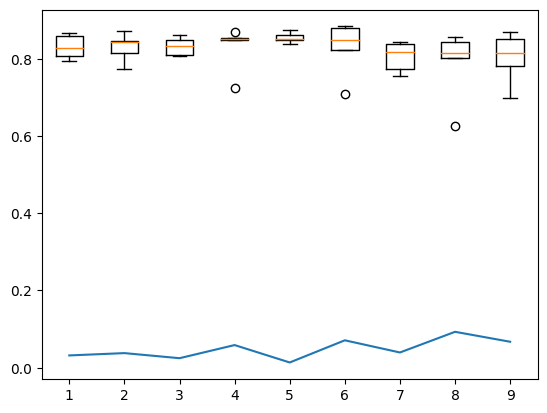

In [ ]:
plt.boxplot(df[df.columns]);
plt.plot([i for i in range(1, len(df.columns) + 1)], df.describe().transpose()["std"]);

We will show its mean and standar deviation too.

In [ ]:
df.describe().transpose()[["mean", "std"]]

,mean,std
"0.05(25, 25)",0.830896,0.031821
"0.05(50, 50)",0.829384,0.037825
"0.05(200, 200)",0.831762,0.024666
"0.15(25, 25)",0.829374,0.058648
"0.15(50, 50)",0.854648,0.013581
"0.15(200, 200)",0.828692,0.070988
"0.25(25, 25)",0.805346,0.039471
"0.25(50, 50)",0.788810,0.092987
"0.25(200, 200)",0.803128,0.067224


We save the results in order to plot them together.

In [ ]:
folds = [["H&S" + r[0], *r[1]] for r in results.items()]
df = pd.read_csv("SSA_testing.csv")
_df = pd.DataFrame(folds, columns = df.columns)
df = pd.concat([df, _df])
df.to_csv("SSA_testing.csv", index = False)

Finally, we can plot an example of inference.

In [ ]:
db = DataBlock(blocks = (ImageBlock, MaskBlock(codes)),
               get_items = get_image_files,
               get_y = get_y_fn,
               splitter = FuncSplitter(lambda x: Path(x).parent.name == "train"),
               item_tfms = [Resize((480,640)), TargetMaskConvertTransform()],
               batch_tfms = Normalize.from_stats(*imagenet_stats)
              )

dls = db.dataloaders(path_images, bs = 4)
learner = unet_learner(dls, **learner_hparams).to_fp16()
learner = learner.load("HideAndSeek")

mask = learner.predict(dls.train_ds[6][0])
print(np.unique(mask[0]))
mask = PILImage.create(decodes(mask[0]))

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[0 1 2 3 4]


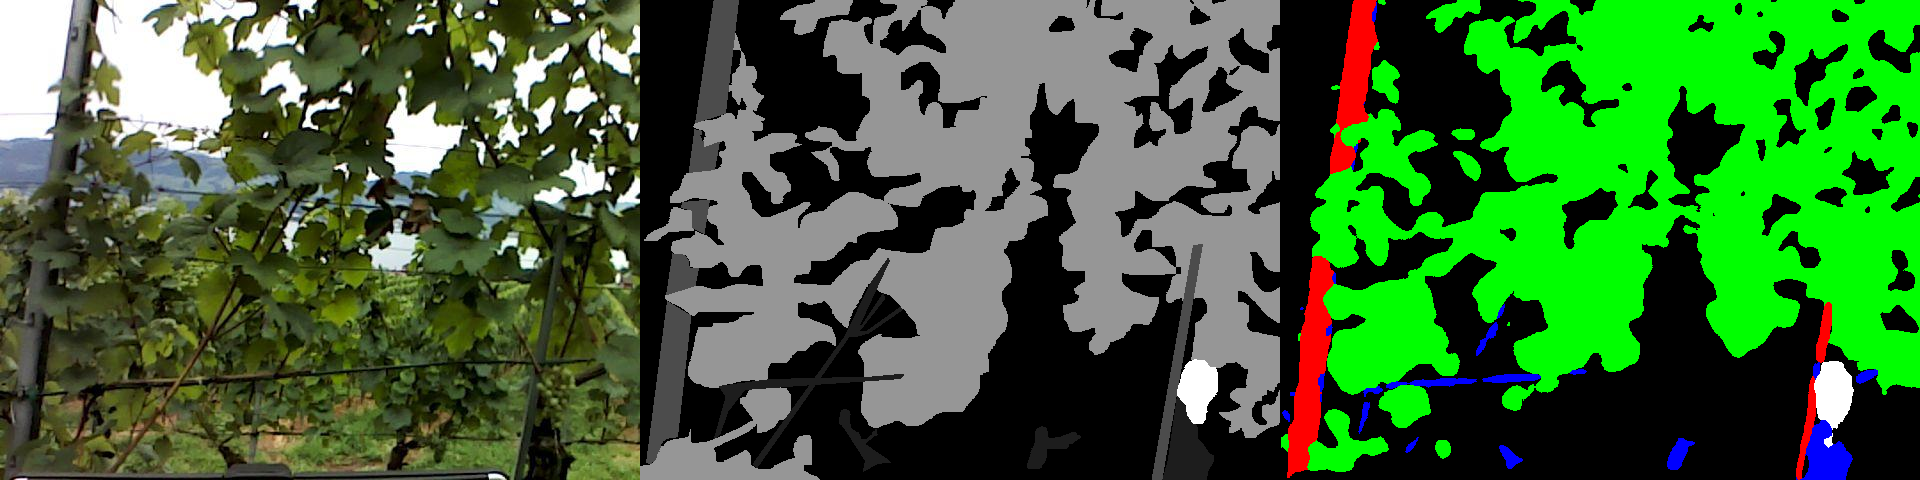

In [ ]:
image_grid([dls.train_ds[6][0], dls.train_ds[6][1], mask], rows = 1, cols = 3)

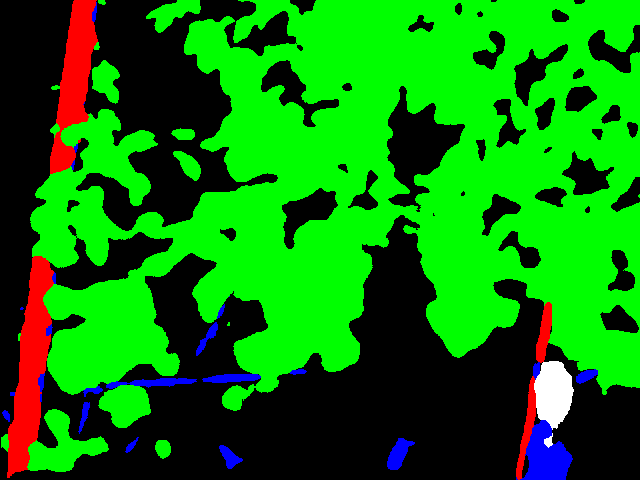

In [ ]:
mask